In [5]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

import pytorch3d.utils as pytorch3d_utils

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./blender_imgs/diff_render_1.obj")

# print(verts)

faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.textures
verts_rgb = torch.zeros_like(verts)[None]  # (1, V, 3)

aaa = torch.zeros_like(verts).unsqueeze(0)  # (1, V, 3)


textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures )

print(aaa.shape)
print(verts_rgb.shape)


torch.Size([1, 5052, 3])
torch.Size([1, 5052, 3])


NameError: name 'focal' is not defined

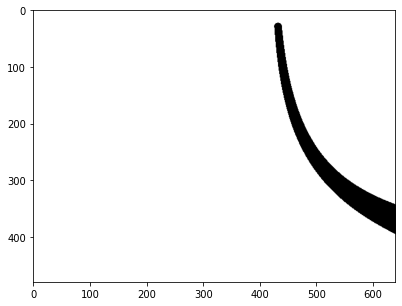

In [6]:
# # Initialize a camera.
# # With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# # So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 

# # R, T = look_at_view_transform(1.0, 0, 0) 
# cam_RT_H = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
# invert_y = torch.tensor([[-1., 0., 0., 0.], [0., -1., 0., 0.], [0., 0.,1., 0.], [0., 0., 0., 1.]])
# cam_RT_H = torch.matmul(invert_y, cam_RT_H)
# R = torch.unsqueeze(cam_RT_H[0:3,0:3], 0)

# T = torch.tensor([[0., 0., 0.]])
# cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

#### ============================================
### From OPENCV Camera to Pytorch3D Camera
#### ============================================
# Given a projection matrix, obtain K, R, t
cam_K = torch.tensor([[883.00220751, 0.0, 320.], [0.0, 883.0022075, 240.], [0., 0., 1.0]], device=device)

cam_RT_H = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]], device=device)
invert_y = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]], device=device)
cam_RT_H = torch.matmul(invert_y, cam_RT_H)

rot = (cam_RT_H[0:3,0:3]).unsqueeze(0)
tvec =  (cam_RT_H[0:3, 3]).unsqueeze(0)


# focal = torch.tensor((cam_K[0, 0],cam_K[1, 1]), dtype=torch.float32).unsqueeze(0)
# principle = torch.tensor((cam_K[0, 2],cam_K[1, 2]), dtype=torch.float32).unsqueeze(0)
cam_mat = cam_K.unsqueeze(0) 

# cameras = PerspectiveCameras(device=device, R=rot, T=trans, focal_length=focal, principal_point=principle, image_size=((480, 640),))

image_size = torch.as_tensor([[480, 640]], device=device)
cameras = pytorch3d_utils.cameras_from_opencv_projection(R=rot, tvec=tvec, camera_matrix=cam_mat, image_size=image_size)



# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=(480,640), 
    blur_radius=0.0, 
    # faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plt.figure(figsize=(10, 5))
plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.axis("off");

images.shape
print(focal)
print(principle)
print(rot)
print(trans)

# p_world = verts[-1].unsqueeze(0)

# p_camera = cam_K @ (rot @ torch.transpose(p_world, 0, 1) - rot @ torch.transpose(trans, 0, 1))

# p_world = verts


# p_after_RT = (rot @ torch.transpose(p_world, 0, 1)).squeeze(0) - (rot @ torch.transpose(trans, 0, 1)).squeeze(0)
# p_camera = cam_K @ p_after_RT

# p_image = p_camera[0:2,:] / p_camera[2,:]

# print(p_image)
# print(p_camera)